# Introduction

This notebook presents **SAGAN: Self-Attention GAN** implementation as the final project of the "Introduction to Deep Learning" course in the MSDS program.  

Within the MSDS course, there was another project focused on CycleGAN, and I really enjoyed working on that project.  

Because of that experience, I decided to take on **SAGAN** for this final project --- building upon what I learned from CycleGAN while also exploring the Attention mechanism, which has become an essential part of many modern deep learning applications.  

SAGAN not only incorporates the Attention mechanism, but also implements important and fascinating techniques such as **pointwise convolution** and **spectral normalization**.  

Although fully understanding these technique is no easy task, I am determined to grasp them firmly through hands-on implementation.  

The ultimate goal of the notebook is to generate **handwritten digit images similar to MNIST** using SAGAN.  

To reduce computational cost, I will focus only on images labeled as '7' and '8' from the MNIST dataset.

# Download the MNIST

In [ ]:
# For loading data

import os
import urllib.request
import zipfile
import tarfile

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np

# For SAGAN implementation
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [ ]:
# prepare a directory
data_dir = './data/'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [ ]:
from sklearn.datasets import fetch_openml

# downloadinig the famous MNIST(28×28=784)
# option:
# as_frame=False: loading data in NumPy array format; we want this because we handle image data rather than table data
# as_frame=True : loading data in pandas DataFrame format
mnist = fetch_openml('mnist_784', version=1, data_home='./data/', as_frame=False)

In [ ]:
# Fetching data
X = mnist.data
y = mnist.target

In [ ]:
# Visualizing the first one in our dataset
plt.imshow(X[0].reshape(28,28), cmap='gray')
print('The label of this image is "{}".'.format(y[0]))

In [ ]:
# adding another directory
data_dir_path = "./data/img_78/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [ ]:
# saving "7" and "8" images into a directory "img_78"
count7 = 0
count8 = 0
max_num = 200  # 200 images each

for i in range(len(X)):

    # saving '7' images into the directory 
    if (y[i] == "7") and (count7<max_num):
        file_path = "./data/img_78/img_7_"+str(count7)+".jpg"
        im_f = (X[i].reshape(28, 28))  # transform the image into the shape 28x28
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # image to PIL format
        # SAGAN will generate 64x64 image, thus the training data is adjusted accordingly.
        # BICUBIC: image interpolation method which is the best among interpolation methods {Nearest neighbor, BiLinear, BiCubic}
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)
        pil_img_f.save(file_path)
        count7 += 1

    # saving '8' images
    if (y[i] == '8') and (count8<max_num):
        file_path = "./data/img_78/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28))  # transforming the image into shape 28x28
        pil_img_f = Image.fromarray(im_f.astype(np.uint8)) # transforming data type to integer
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # expand to 64x64
        pil_img_f.save(file_path)
        count8 += 1        

In [ ]:
# Setup seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# SAGAN Module

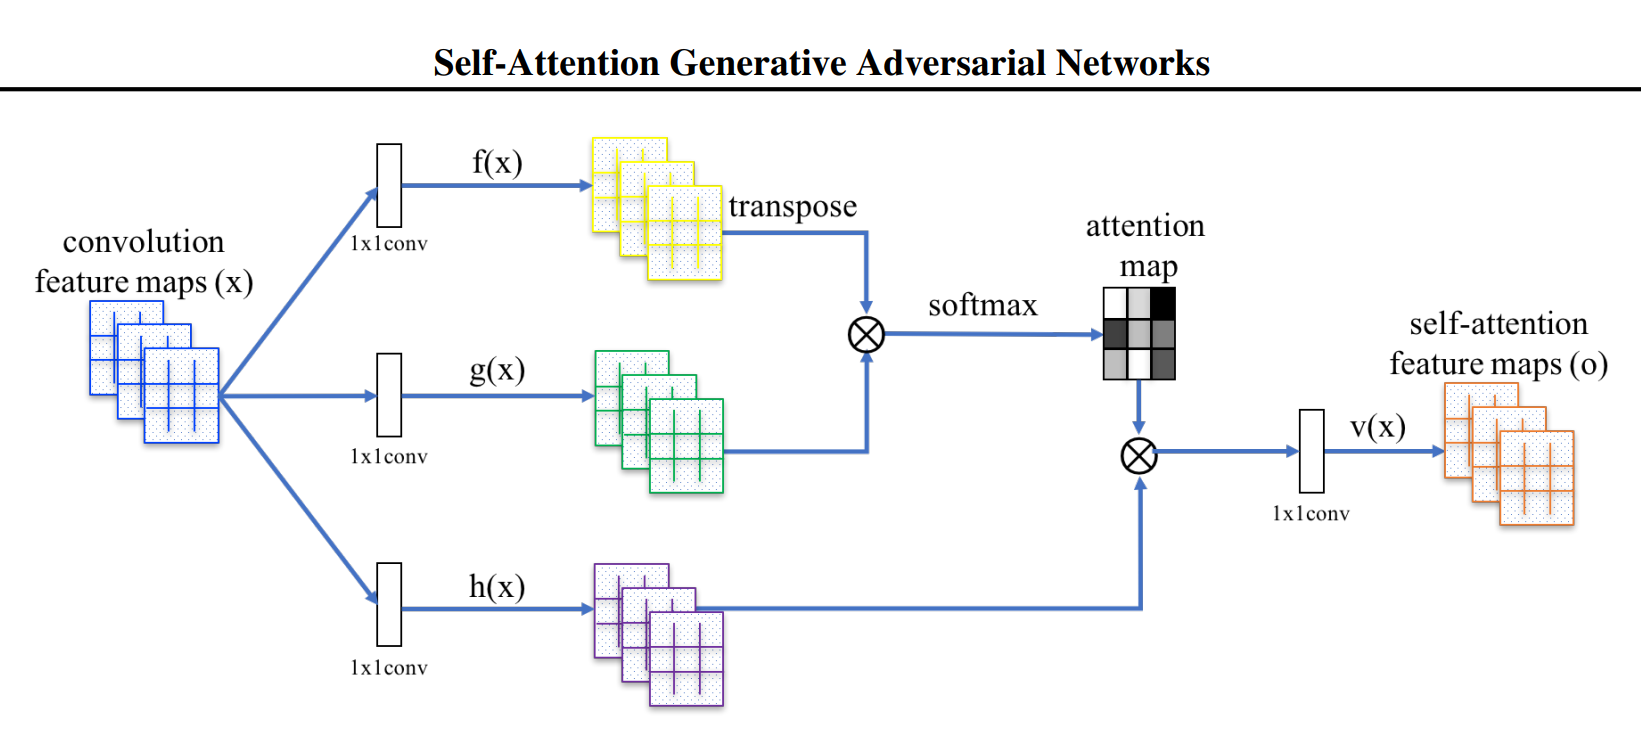
The figure is excerpted from the Self-Attention GAN paper.  

If we replace $f(x)$ with "key", $g(x)$ with "query", and $h(x)$ with "value" in the figure, we can see that this is exactly the same attention mechanism found in papers such as Transformer.  

The formula for the Scaled Dot-Product Attention used in Transformer, 
$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt D})V$$

is directly represented in the figure.

Resource:  
Self-Attention Generative Adversarial Networks  
arXiv:1805.08318

# Differences between Self Attention and Cross Attention

The transformer architecture includes both **Self Attention** and **Cross Attention** mechanisms.  
Some models, such as BERT and SAGAN, only use Self Attention, but here we will briefly clarify the differences between the two.  

### Self Attention
Self Attention is a mechanism that compares different parts within the same input data to capture relationships.  
In the case of images, it calculates how much one pixel (or patch) relates to other pixels within the same features.  
Because it refers to itself within the same state, it is called Self Attention.  

### Cross Attention
Cross Attention, on the other hand, compares different data sources.  
For example, in the Transformer architecture, Cross Attention is used when the Decoder refers to the features extracted by the Encoder.  
More specifically, the Encoder uses Self Attention to extract features from the input data, and the Decoder uses those features, along with the model's own previous outputs, to make predictions and generates outputs.  

### Common Point
Both Self Attention and Cross Attention share the same core computation:
They both calculate the inner product between Query and Key.

In [ ]:
class Self_Attention(nn.Module):
    """Self Attention Layer"""

    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()

        # Pointwise Convolution
        # (explained in the Markdown cell below)
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)
            
        # softmax scaling for the attention map
        # S = q^T k -> shape: (N_query, N_key)
        # Softmax(dim=-2) applies softmax along the 2nd-to-last dimension
        # which is query axis in this case.
        # Example attention map after applying softmax;
        #          key_1 key_2 key_3
        # query_1   0.5   0.3   0.2
        # query_2   0.2   0.7   0.1
        # query_3   0.4   0.1   0.5
        self.softmax = nn.Softmax(dim=-2)
    
        # gamma: hyperparameter coefficient for self attention map. 
        # output = x + gamma * o
        # If gamma = 0, there is no effect of self attention.
        # If gamma = 1, the output of self attention is added as is.
        # If gamma > 1, the weight of self attention has more effect.
        # Through the training, model will learn how much weight it should apply on self attention.
        # default setting: gamma = 0
    
        # nn.Parameter() defines a learnable paramete in neural network.
        # Since gamma is a scalar coefficient, we initialize it as a tensor with a single element (1).
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        X = x
    
        # convolute, then reshape: view() is a reshape function for tensor
        # reshaping query size from [B, C, H, W] to [B, C, N] where N = HxW
        proj_query = self.query_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3]) # [Batch_size, Channel, N]
        # transposing proj_query
        proj_query = proj_query.permute(0, 2, 1) # [B, N, C]
        # key as same as query
        proj_key = self.key_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3]) # [B, C, N]
    
        # bmm(): batch matrix multiplication; multiplying matrix in each batch
        S = torch.bmm(proj_query, proj_key)
    
        # normalizing the attention to [0, 1] range
        # attention_map = self.softmax(S) 
        attention_map_T = self.softmax(S)  # 行i(Query)方向の和を1にするｿﾌﾄﾏｯｸｽ
        attention_map = attention_map_T.permute(0,2,1)  # 転置を取る
        
        # deriving self attention map
        proj_value = self.value_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3]) # [B,C,H,W]->[B,C,N]
        o = torch.bmm(proj_value, attention_map.permute(
                      0, 2, 1))
    
        # reshape o: self attention map to the size of X tensor
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        # attention being added to the input x
        # gamma scales the weight of attention
        out = x + self.gamma * o
    
        return out, attention_map

# Pointwise Convolution
This technique became widely known through the paper **Network in Network**.  

It involves inserting a 1x1 convolution layer between standard convolution layers in a CNN.  

This allows for increasing or decreasing the number of channels **without changing the spatial dimentions** of the feature map.  

Reducing the number of channels while keeping the image size the same leads to two main benefits:  
- Feature compression
- Reduced computational cost  

This structure is often referred to as a **bottleneck block**, and it is frequently used in optimized CNN architectures to improve efficiency.  

Resource:
Network in network,  
Min Lin, Qiang Chen, Shuicheng Yan.  
arXiv:1312.4400

# Generator

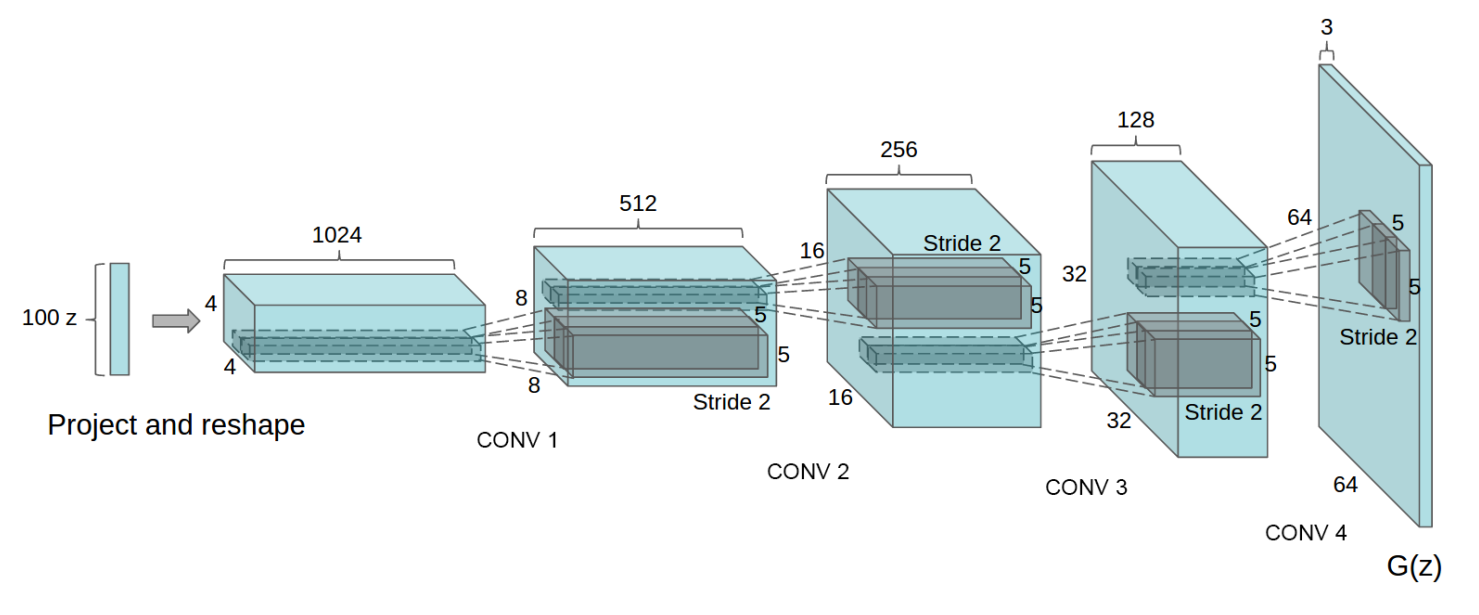
The figure is excerpted from the DCGAN paper.  

The generator takes a random vector as the seed and gradually generates an image of the desired size by repeatedly applying transposed convolutions.

Our generator is composed of five convolutional layers, similar to the architecture shown in the figure.  

The key difference are that our 4th and 5th convolutional layers incorporate attention mechanisms, the input noise vector is 20-dimensional instead of 100-dimensional, and the final layer outputs a single channel instead of three.  

This design choice reflects our focus on generating **grayscale** and **relatively simple digit images**, allowing us to reduce computational complexity while maintaining effective learning. 

Resource:  
Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks (DCGAN)  
Alec Radford & Luke Metz, Soumith Chintala  
arXiv:1511.06434

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        # input size: (B:1,Ch:20,H:1,W:1)
        self.layer1 = nn.Sequential(
            # Applying Spectral Normalilzation
            # (explained in the Markdown cell below)
            # ConvTranspose2d(in_ch,out_ch,ker_size,stride,padding)
            nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size * 8,
                                                      kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        # input size: (1,512,4,4)
        self.layer2 = nn.Sequential(
            # Adding Spectral Normalilzation
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*8, image_size*4,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))

        # input size: (1,256,8,8)
        self.layer3 = nn.Sequential(
            # Adding Spectral Normalilzation
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*4, image_size*2,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))

        # Adding Self Attention layer
        self.self_attention1 = Self_Attention(in_dim=image_size*2)
        
        # input size: (1,128,16,16)
        self.layer4 = nn.Sequential(
            # Adding Spectral Normalilzation
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*2, image_size,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        # Adding Self Attention layer
        self.self_attention2 = Self_Attention(in_dim=image_size)
        
        # input size: (1,64,32,32)
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())

        # output size: (1,1,64,64)

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2 

# Spectral Normalization
Spectral Normalization standardizes the network's weight parameters (in contrast to Batch Normalization, which normalizes the input data).  

For a GAN to function effectively, the **Discriminator** must satisfy **Lipschitz continuity**.  

Lipschitz continuity means that small changes in the image lead to only small changes in the Discriminator's output.  

Conversely, if small changes in the input cause large, erratic changes in the output, the GAN fails to learn properly.  

To enforce Lipshitz continuity, Spectral Normalization divides each layer's weight parameters by their largest singular value, ensuring that the input tensor to a layer does not get excessively amplified in the output tensor.



### Let's check how the generator is working

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# input noise
input_z = torch.randn(1, 20)

# resize the tensor to (batch_size=1, ch=20, H=1, W=1)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# output a generated image
fake_images, attention_map1, attention_map2 = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, cmap='gray')
plt.show()

As expected, the generator outputs a noisy image since it hasn't been trained yet (no weights have been updated).  
Still, it's working correctly in the sense that it produces output that can be passed to the discriminator.

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
    
        self.layer1 = nn.Sequential(
            # Adding Spectral Normalilzation
            # Conv2d(in_ch,out_ch,ker_size,stride,padding)
            nn.utils.spectral_norm(nn.Conv2d(1, image_size, 
                                             kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
    
        self.layer2 = nn.Sequential(
            # Adding Spectral Normalilzation
            nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, 
                                             kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
    
        self.layer3 = nn.Sequential(
            # Adding Spectral Normalilzation
            nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4,
                                             kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
    
        # Adding Self Attention layer
        self.self_attention1 = Self_Attention(in_dim=image_size*4)
    
        self.layer4 = nn.Sequential(
            # Adding Spectral Normalilzation
            nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8,
                                             kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        
        # Adding Self Attention layer
        self.self_attention2 = Self_Attention(in_dim=image_size*8)
    
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
    
        return out, attention_map1, attention_map2

### Let's check how the discriminator is working

In [ ]:
D = Discriminator(z_dim=20, image_size=64)

# Generating a fake image
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, _, _ = G(input_z)

# Feeding a fake image into D
d_out, attention_map1, attention_map2 = D(fake_images)
print('d_out', d_out)

# Normalizing D's output to [0,1] range by Sigmoid function
print(nn.Sigmoid()(d_out))

Output：  
d_out: -0.0539 (close to zero)  

This is the raw score, or logit, output by the Discriminator.  

When a logit close to zero is converted to a probability using the **sigmoid** function, the result is close to 0.5 (in this case, 0.4865).  

Since the Discriminator is untrained at this stage, it cannot yet distinguish real from fake images well -- so it tends to give probabilities around 0.5, effectively making random guesses.

# DataLoader

In [ ]:
def make_datapath_list():
    """Preparing a filepath list for training and evaluating image data as well as the attention data"""
    train_img_list = list() # store an imagefile path

    for img_idx in range(200):
        img_path = './data/img_78/img_7_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)

        img_path = './data/img_78/img_8_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)

    return train_img_list

In [ ]:
class ImageTransform():
    """Image preprocessing"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [ ]:
class GAN_Img_Dataset(data.Dataset):
    """Image dataset class; inherits PyTorch Dataset class"""
    
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        """return # of images"""
        return len(self.file_list)

    def __getitem__(self, index):
        """Obtain the preprocessed image data in Tensor format"""

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # image preprocessing
        img_transformed = self.transform(img)

        return img_transformed

In [ ]:
# instantiating DataLoader

# preparing file list
train_img_list = make_datapath_list()

# Dataset
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list = train_img_list, transform = ImageTransform(mean, std))

# DataLoader
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# Let's test the dataloader
batch_iterator = iter(train_dataloader)  # transform to an iterator
imges = next(batch_iterator)  # getting the first element
print(imges.size())

# Training

In [ ]:
# function to train a model
def train_model(G, D, dataloader, num_epochs):
    # checking GPU availability
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device', device)

    # optimizer setting
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # Define loss function 
    #  -> switched to hinge version of adversarial loss
    # criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    # hyperparameters
    z_dim = 20
    mini_batch_size = 64

    # allocating the network to GPU
    G.to(device)
    D.to(device)

    G.train() # setting training mode
    D.train() # setting training mode

    # If the network is static, it can be fasten.
    torch.backends.cudnn.benchmark = True

    # number of images
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # iteration counter
    iteration = 1
    logs = []

    # epoch loop
    for epoch in range(num_epochs):
        # measure time (start time)
        t_epoch_start = time.time()
        epoch_g_loss = 0.0 # sum of loss of an epoch
        epoch_d_loss = 0.0 # sum of loss of an epoch

        print('-------------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------------')
        print(' (train) ')

        # loops taking minibatches from the dataloader
        for i, images in enumerate(tqdm(dataloader, desc=f'Epoch {epoch+1}')):

            # if GPU is available:
            images = images.to(device)

            # The discriminator training
            # checking a batch size
            mini_batch_size = images.size()[0]
            # labeling '1' for real images, '0' for fake images 
            # label_real = torch.full((mini_batch_size,), 1).to(device)
            # label_fake = torch.full((mini_batch_size,), 0).to(device)

            # Let the discriminator label for 'real image'.
            d_out_real, _, _ = D(images)

            # Generating random noise `input_z` 
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            # view() means reshape the tensor.
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            # Feeding it into the generator to generate `fake image'
            fake_images, _, _ = G(input_z)
            # Let the discriminator label for 'fake image'.
            d_out_fake, _, _ = D(fake_images)

            # calculating loss for real-images and fake-images, and sum them up
            #  -> switched to hinge version of adversarial loss
            # d_loss_real = criterion(d_out_real.view(-1), label_real)
            # d_loss_fake = criterion(d_out_real.view(-1), label_fake)
            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            # if d_out_real is greater than 1, the loss will be 0.
            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            # if d_out_fake is lesser than -1, the loss will be 0.
            
            d_loss = d_loss_real + d_loss_fake
            
            # initializing gradients
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            # backpropatation
            d_loss.backward()  
            # updating parameters
            d_optimizer.step() 

            # The generator training
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            # view() means reshape the tensor
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            # Feeding it into G to generate `fake image'
            fake_images, _, _ = G(input_z)
            # Let D label for 'fake image'.
            d_out_fake, _, _ = D(fake_images)

            # loss calculation
            g_loss = -d_out_fake.mean()

            # backpropagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # keep record
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # The loss and accuracy rate per epoch phase
        t_epoch_finish = time.time()
        print('-------------------')
        print('epoch {} || Epoch_D_loss:{:.4f} ||Epoch_G_loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D

These specific initialization values (in below cell) aren't backed by solid theory, but they've been shown to help in practice -- especially for GANs like DCGAN and SAGAN. So while not mandatory, they're often used to improve performance and training stability.

In [ ]:
# Initializing network
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Initializing Conv2d and ConvTranspose2d
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # Initializing BatchNorm2d
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# executing initialization
# G.apply(weights_init)
# D.apply(weights_init)

# print('network initialization completed!')

In [ ]:
# executing initialization
G.apply(weights_init)
D.apply(weights_init)

# Train and validate
# maybe took about 15 minutes
# num_epochs = 300
num_epochs = 170

G_update, D_update = train_model(
    G, D, dataloader = train_dataloader, num_epochs=num_epochs)

# Mode Collapse occurred!

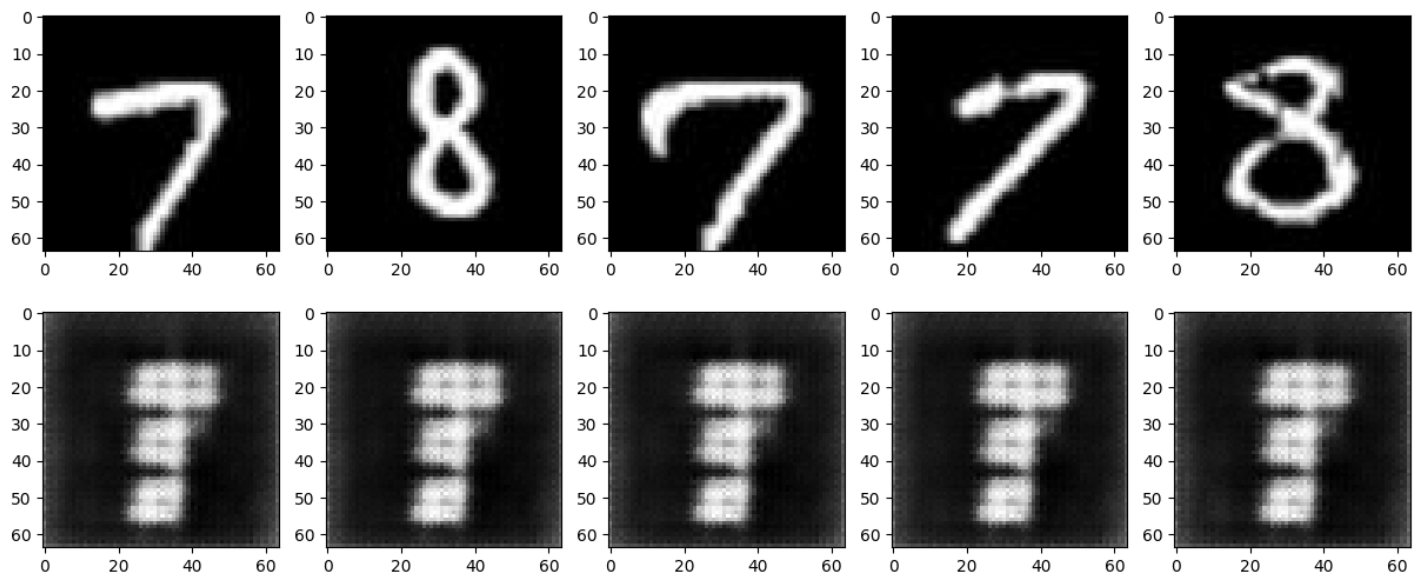

While generating images, I encountered a problem known as *Mode Collapse*.  

This occurs when the generator succeeds in fooling the discriminator by repeatedly generating similar-looking images, and ends up producing only those limited patterns.  

To address this issues, I tried;
* resetting the training environment (e.g., switching the computer device) 
* initializing the network (using `weights_init` function), 
* tuning hyperparameters such as the learning rate, batch size, and number of training epochs.

In [ ]:
# Visualizing generated images

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# generaitng random numbers for input
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# generating image
G_update.eval()
fake_images, am1, am2 = G_update(fixed_z.to(device))

# training data
batch_iterator = iter(train_dataloader) # transform to iterator
images = next(batch_iterator) # extracting the first element

# output
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # show train image in upper row
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')

    # show generated image in lower row
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

The top row shows training images, and the bottom row shows generated images.

In [ ]:
# output an attention map
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # show generated image in upper row
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

    # show attention map pixel data in lower row
    plt.subplot(2, 5, 5+i+1)
    am = am1[i].view(16, 16, 16, 16)
    am = am[7][7]  # A pixel at 7th row and 7th column
    plt.imshow(am.cpu().detach().numpy(), 'Reds')

# Attention Map
The attention map shows how the pixel at position (7,7) -- which acts as the **query** -- attends to all other pixels in the 16x16 feature map.  

Pixels that are attended to are shown in **red**, while those that are not are shown in **white**.  

(All other pixels serves as **keys** corresponding to their values.)  

Now, let's try changing the query location.  

For example, let's take the pixel at position (7,7) and the pixel at position (5,12) as separate queries, and compute their respective attention maps by displaying them stacked vertically.  

In [ ]:
# output two attention maps with different query positions
fig = plt.figure(figsize=(15, 9))

for i in range(5):
    # show generated image (same for both attention maps)
    plt.subplot(3, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')
    plt.axis('off')
    if i == 0:
        plt.title("Generated Image")

    # Attention map for query at (7, 7)
    plt.subplot(3, 5, 5 + i + 1)
    am = am1[i].view(16, 16, 16, 16)
    am_7_7 = am[7][7]
    plt.imshow(am_7_7.cpu().detach().numpy(), 'Reds')
    plt.axis('off')
    if i == 0:
        plt.title("Attention @ (7, 7)")

    # Attention map for query at (5, 12)
    plt.subplot(3, 5, 10 + i + 1)
    am_5_12 = am[5][12]
    plt.imshow(am_5_12.cpu().detach().numpy(), 'Reds')
    plt.axis('off')
    if i == 0:
        plt.title("Attention @ (5, 12)")

plt.tight_layout()
plt.show()

Each pixel has its own unique attention map, which indicates that it builds independent relationships with other pixels.  

As training progresses and the number of epochs increases, the attention maps tend to become almost entirely white.  

This could be interpreted as the model no longer focusing on its attention on specific pixels once a certain level of learning has achieved. 

# Conclusion

DCGAN generates images by capturing local features through transposed convolution.  

However, this approach has a limitation: when local features are simply enlarged, it becomes difficult for the model to capture the global structure of the image.  

SAGAN addresses this issue by incorporating the attention mechanism, allowing each pixel to attend to the entire image during generation.  

Although Mode Collapse is a challenging problem, it can be mitigated by using Spectral Normalization to stabilize the update of weight parameters, along with fine-tuning of hyperparameters such as learning rate and batch-size by the programmer.  

Thank you for reading!  